<a href="https://colab.research.google.com/github/nguyengiapphuongduy/ml-191/blob/master/support_vector_machine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers, printing
np.set_printoptions(suppress=True)
solvers.options['show_progress'] = False
printing.options['dformat'] = '%.1f'

# Class SVM

In [0]:
class SVM():
    def __init__(self, colors=('orange', 'green'), dual=True, eps=0.001, kernel='linear'):
        self.__colors = colors
        self.dual = dual
        self.eps = eps
        self.kernel = self.Kernel(kernel)

    class Kernel:
        def __init__(self, __str__, gamma=1, r=1, d=1):
            self.__str__ = __str__
            self.set_coef()

        def set_coef(self, gamma=1, r=1, d=1):
            self.gamma = gamma
            self.r = r
            self.d = d

        def calc(self, X1, X2): # column-equals
            if self.__str__ == 'poly':
                return (X1.dot(X2.T)*self.gamma + self.r)**self.d
            elif self.__str__ == 'sigmoid':
                return np.tanh(X1.dot(X2.T)*self.gamma + self.r)
            elif self.__str__ == 'rbf':
                N1, N2 = X1.shape[0], X2.shape[0]
                norm = -2*X1.dot(X2.T) +\
                    (X1*X1).sum(axis=1).reshape(N1, 1).dot(np.ones(N2).reshape(1, N2)) +\
                    np.ones(N1).reshape(N1, 1).dot((X2*X2).sum(axis=1).reshape(1, N2))
                return np.exp(-self.gamma*norm)
            else:
                return X1.dot(X2.T)

    def fit(self, X, y, C=0, plot=True):
        X = X.astype(np.double)
        y = y.reshape(X.shape[0], 1).astype(np.double)
        if C != 0 and C is not None:
            self.__fit_soft(X, y, C)
        elif self.dual == False and self.kernel == 'linear':
            self.__fit_primal(X, y)
        else:
            self.__fit_dual(X, y)
        if plot:
            self.__plot(X, y)

    def __fit_soft(self, X, y, C):
        K = matrix(self.kernel.calc(X, X)*y.dot(y.T))
        p = matrix(np.c_[-np.ones(N)])
        G = matrix(np.concatenate((-np.identity(N), np.identity(N))))
        h = matrix(np.concatenate((np.c_[np.zeros(N)], C*np.c_[np.ones(N)])))
        A = matrix(y.T)
        b = matrix([0.])

        solution = solvers.qp(K, p, G, h, A, b)
        alpha = np.array(solution['x'])
        mar = np.where((alpha > self.eps) * (alpha < C - self.eps))[0]
        sup = np.where(alpha > self.eps)[0]
        self.asup = alpha[sup]*y[sup]
        b = (y[mar] - self.kernel.calc(X[mar], X[sup]).dot(self.asup)).T.mean()
        w = self.asup.T.dot(X[sup])[0]
        self.support_indices = sup
        self.support_vectors = X[sup]
        self.coef_ = w.reshape(len(w), 1)
        self.dual_coef_ = alpha[sup]
        self.intercept_ = [b]

    def __fit_dual(self, X, y):
        K = matrix(self.kernel.calc(X, X)*y.dot(y.T))
        p = matrix(np.c_[-np.ones(N)])
        G = matrix(-np.identity(N))
        h = matrix(np.c_[np.zeros(N)])
        A = matrix(y.T)
        b = matrix([0.])

        solution = solvers.qp(K, p, G, h, A, b)
        alpha = np.array(solution['x'])
        sup = np.where(alpha > self.eps)[0]
        self.asup = alpha[sup]*y[sup]
        b = (y[sup] - self.kernel.calc(X[sup], X[sup]).dot(self.asup)).T.mean()
        w = self.asup.T.dot(X[sup])[0]
        self.support_indices = sup
        self.support_vectors = X[sup]
        self.coef_ = w.reshape(len(w), 1)
        self.dual_coef_ = alpha[sup]
        self.intercept_ = [b]

    def __fit_primal(self, X, y):
        X1 = np.concatenate((X, np.ones((N, 1))), axis=1)
        M = X1.shape[1]

        K = np.identity(M); K[-1, -1] = 0
        K = matrix(K)
        p = matrix(np.zeros((M, 1)))
        G = matrix(X1 * np.tile(-y, (1, M)))
        h = matrix(-np.ones((N, 1)))

        solution = solvers.qp(K, p, G, h)
        wb = np.array(solution['x'])
        dist = X1.dot(wb)
        self.support_indices = np.where(np.isclose(dist, 1) + np.isclose(dist, -1))[0]
        self.support_vectors = X[self.support_indices]
        self.coef_ = wb[:-1]
        self.intercept_ = wb[-1]

    def predict(self, B):
        B = np.array(B)
        if len(B.shape) <= 1:
            B = B.reshape(1, len(B))
        if self.kernel == 'linear':
            return self.coef_.dot(B) + self.intercept_
        else:
            return self.kernel.calc(B, self.support_vectors)\
                .dot(self.asup) + self.intercept_

    def __plot(self, X, y):
        '''Predict and color the sample space'''

        colors = self.__colors
        left, right = X[:,0].min() - 1, X[:,0].max() + 1
        bot, top = X[:,1].min() - 0.1, X[:,1].max() + 0.1
        Xpos = X[np.where(y > 0)[0], :]
        Xneg = X[np.where(y < 0)[0], :]

        plt.figure(figsize=(10,10))
        plt.axis((left, right, bot, top))
        plt.scatter(Xneg[:,0], Xneg[:,1], c=colors[0])
        plt.scatter(Xpos[:,0], Xpos[:,1], c=colors[1])
        sup = self.support_indices
        plt.scatter(X[sup,0], X[sup,1], s=[150], facecolors='none',
                    edgecolors='gray', label='support vectors')

        # fill color
        xx, yy = np.mgrid[left:right:0.01, bot:top:0.01]
        space = np.dstack((xx.ravel(), yy.ravel()))[0]
        pred = self.predict(space).reshape(xx.shape)
        plt.contourf(xx, yy, np.sign(pred), alpha=0.1, colors=self.__colors)
        plt.contour(xx, yy, pred, colors=['gray'], levels=[-1, 0, 1],
                    linestyles=['--', '-', '--'])
        plt.legend()
        plt.show()
        pass


### Plot function for linear boundaries

In [0]:
def plot_svm(X, y, w, b, sup=None, colors = ('orange', 'green')):
    left, right = X[:,0].min() - 1, X[:,0].max() + 1
    bot, top = X[:,1].min() - 0.1, X[:,1].max() + 0.1
    Xpos = X[np.where(y > 0)[0], :]
    Xneg = X[np.where(y < 0)[0], :]

    plt.figure(figsize=(10,10))
    plt.axis((left, right, bot, top))
    plt.scatter(Xneg[:,0], Xneg[:,1], c=colors[0])
    plt.scatter(Xpos[:,0], Xpos[:,1], c=colors[1])

    # linear w0*x + w1*y + b = 0
    xplot = np.linspace(left, right, 100)
    yplot = -(w[0]*xplot + b) / w[1]
    y_neg = -(w[0]*xplot + b + 1) / w[1]
    y_pos = -(w[0]*xplot + b - 1) / w[1]
    plt.plot(xplot, yplot, '-', color='red', linewidth=2, label='boundary')
    plt.plot(xplot, y_neg, '--', color=colors[0], linewidth=1, label='(-1) margin')
    plt.plot(xplot, y_pos, '--', color=colors[1], linewidth=1, label='(+1) margin')
    if sup is not None:
        plt.scatter(X[sup,0], X[sup,1], s=[150],
                    facecolors='none', edgecolors='gray', label='support vectors')
    # fill color
    upper = top*np.ones(xplot.shape[0])
    lower = bot*np.ones(xplot.shape[0])
    plt.fill_between(xplot, yplot, lower, alpha=0.1, color=colors[0], label='negative class')
    plt.fill_between(xplot, yplot, upper, alpha=0.1, color=colors[1], label='positive class')
    plt.legend()
    plt.show()
    pass

# Hard magin

### Generate

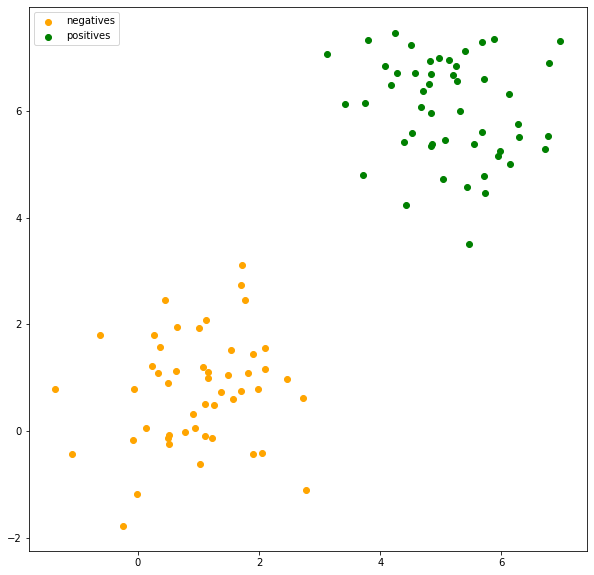

In [0]:
num_negative, num_positive = 50, 50
negatives = np.random.multivariate_normal([1, 1], [[1, 0], [0, 1]], num_negative)
positives = np.random.multivariate_normal([5, 6], [[1, 0], [0, 1]], num_positive)
samples = np.concatenate((negatives, positives))
labels = np.concatenate((-np.ones(num_negative), np.ones(num_positive)))
N = num_negative + num_positive

plt.figure(figsize=(10,10))
plt.scatter(negatives[:,0], negatives[:,1], label='negatives', c='orange')
plt.scatter(positives[:,0], positives[:,1], label='positives', c='green')
plt.legend()
pass

### Apply

From sklearn: 
[[0.58653714 0.49044   ]]
[-3.53408607]

Implemented:
[[0.58653687]
 [0.49043981]]
[-3.5340844768083497]


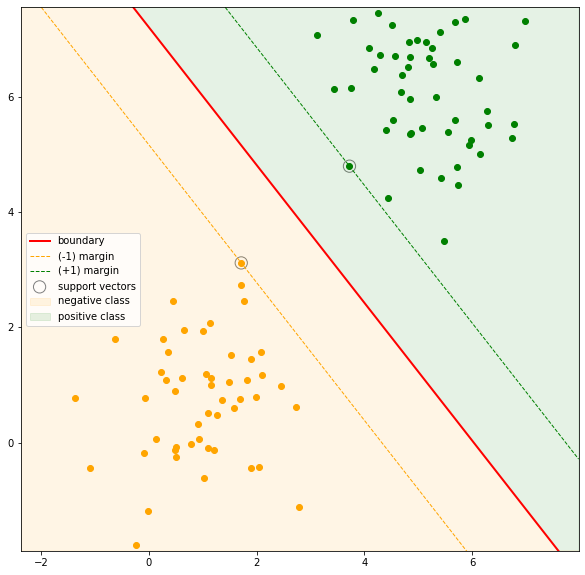

In [0]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='linear')
svclassifier.fit(samples, labels)

model = SVM()
model.fit(samples, labels, plot=False)
w, b, s = model.coef_, model.intercept_, model.support_indices

print('From sklearn: ', svclassifier.coef_, svclassifier.intercept_, '',
      'Implemented:', w, b, sep='\n')
plot_svm(samples, labels, w, b, s)

# Soft margin

### Generate

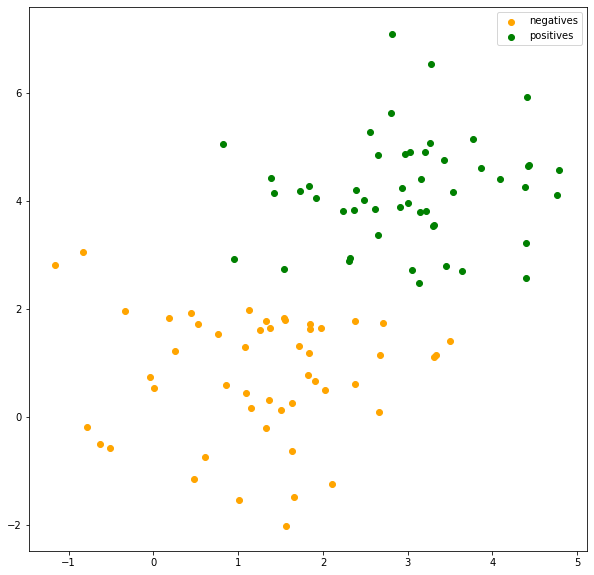

In [0]:
num_negative, num_positive = 50, 50
negatives = np.random.multivariate_normal([1, 1], [[1, 0], [0, 1]], num_negative)
positives = np.random.multivariate_normal([3, 4], [[1, 0], [0, 1]], num_positive)
soft_samples = np.concatenate((negatives, positives))
soft_labels = np.concatenate((-np.ones(num_negative), np.ones(num_positive)))
N = num_negative + num_positive

plt.figure(figsize=(10,10))
plt.scatter(negatives[:,0], negatives[:,1], label='negatives', c='orange')
plt.scatter(positives[:,0], positives[:,1], label='positives', c='green')
plt.legend()
pass

### Apply

From sklearn: 
[[0.51235506 1.5444946 ]]
[-4.75544535]

Implemented:
[[0.5123553 ]
 [1.54449544]]
[-4.755447667038236]



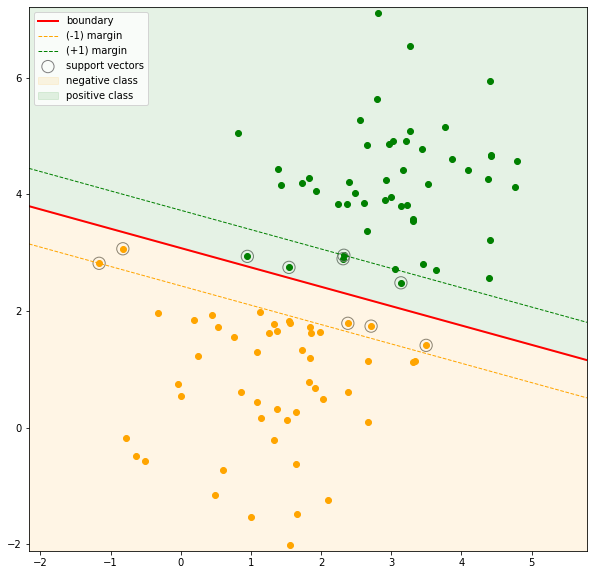

In [0]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='linear', C=0.5)
svclassifier.fit(soft_samples, soft_labels)

model = SVM(eps=0.01)
model.fit(soft_samples, soft_labels, C=0.5, plot=False)
w, b, s = model.coef_, model.intercept_, model.support_indices

print('From sklearn: ', svclassifier.coef_, svclassifier.intercept_, '',
      'Implemented:', w, b, '', sep='\n')
plot_svm(soft_samples, soft_labels, w, b, s)

# SVM Kernel

### XOR problem

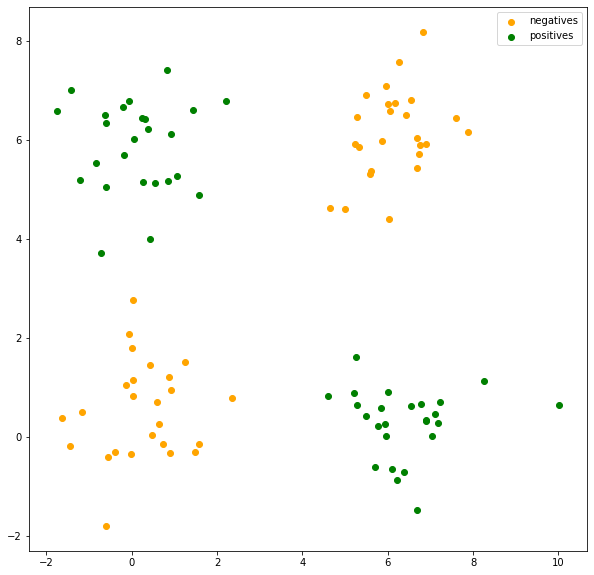

In [0]:
num_negative, num_positive = 50, 50
negatives = np.random.multivariate_normal([0, 0], [[1, 0], [0, 1]], num_negative//2)
negatives = np.concatenate((negatives, np.random.multivariate_normal([6, 6], [[1, 0], [0, 1]], num_negative//2))) 
positives = np.random.multivariate_normal([0, 6], [[1, 0], [0, 1]], num_positive//2)
positives = np.concatenate((positives, np.random.multivariate_normal([6, 0], [[1, 0], [0, 1]], num_positive//2)))
xor_samples = np.concatenate((negatives, positives))
xor_labels = np.concatenate((-np.ones(num_negative), np.ones(num_positive)))
N = num_negative + num_positive

plt.figure(figsize=(10,10))
plt.scatter(negatives[:,0], negatives[:,1], label='negatives', c='orange')
plt.scatter(positives[:,0], positives[:,1], label='positives', c='green')
plt.legend()
pass

### Solution using linear kernel

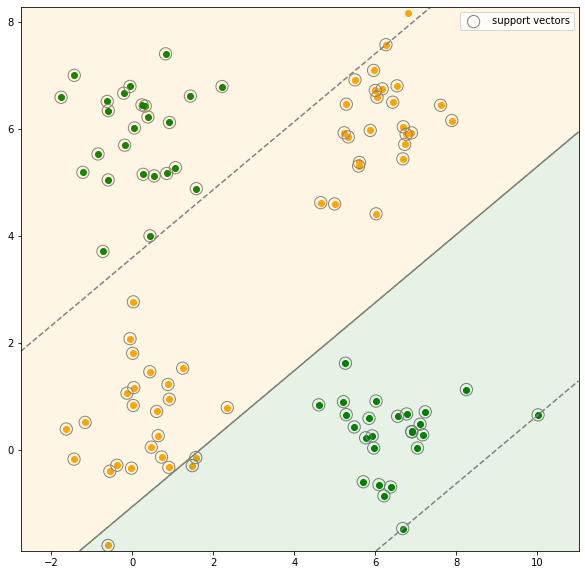

In [0]:
model = SVM(kernel='linear', eps=0.001)
model.fit(xor_samples, xor_labels, C=2)

### Solution using polynomial kernel

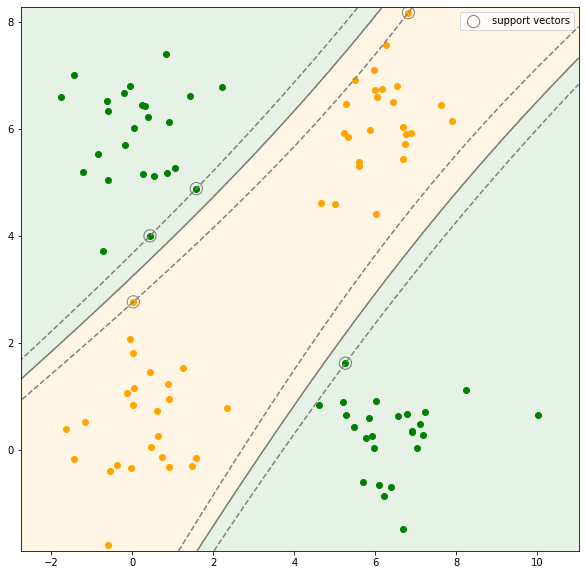

In [0]:
model = SVM(kernel='poly', eps=0.001)
model.kernel.set_coef(d=2)
model.fit(xor_samples, xor_labels, C=2)

### Solution using RBF kernel

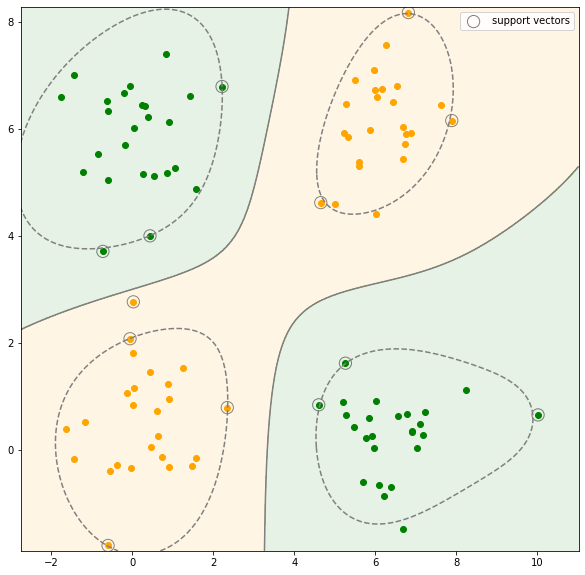

In [0]:
model = SVM(kernel='rbf', eps=0.1)
model.kernel.set_coef(gamma=0.1, r=0)
model.fit(xor_samples, xor_labels, C=2)